# RABiTPy - Rapid Artificially Intelligent Bacterial Tracker (ver 1.1.0)
Last updated: 17-Mar-2025

## Introduction
RABiTPy is a comprehensive package designed to track and analyze the movement of microorganisms in video files or timelapse images. This package provides the tools for loading files, object identification (via either thresholding or AI-based methods), tracking in simple and crowded conditions, and analyzing the movement of various organisms.

### Features
- Capture: Load video files or image sequences and convert them into frames.
- Identify: Detect and identify microorganisms using thresholding or AI-based masking.
- Tracker: Track identified organisms across frames, join the tracks, apply filters to retain meaningful tracks.
- Stats: Analyze the tracs organisms to calculate speed, movement patterns, mean-squared displacement, and other metrics.

### Documentation

For detailed usage and examples, refer to the documentation for each class:
- [Capture Class Documentation](documentation/capture.md)
- [Identify Class Documentation](documentation/identify.md)
- [Tracker Class Documentation](documentation/track.md)
- [Stats Class Documentation](documentation/stats.md)


## Walkthrough(Demo)

This notebook provides an in-depth guide to understanding and working through all the steps needed to properly use the package. In this walkthrough, a user will get a clear view of how to set up, configure, and run the package according to their needs.

We will use an example video throughout the notebook to illustrate the process. This example will enable us to convey practical insight and further realize the functionalities offered by the package. Be it the first time, or you want to go deeper, this walkthrough will help you through all the steps to make everything as smooth and efficient as possible.

At the bottom of the notebook, we briefly survey the more advanced features of RABiTPy. To delve deeper, please explore the [rest of the documentation](https://github.com/indraneel207/RABiTPy) for additional information

### Installation Instructions

To install this Python-based package, please use the pip installer. Below are the necessary commands to execute prior to usage.

**Important:** Ensure that Python version `3.10.11` is installed, as it is required for this package to function correctly.

1. First, install the package:

In [1]:
%pip install RABiTPy

2. Additionally, this package relies on another package, Omnipose. To ensure compatibility with `RABiTPy`, you must install a specific version of Omnipose using a custom commit, as the hosted version does not meet our requirements. Please execute the following command to install the appropriate version.

In [2]:
%pip install git+https://github.com/kevinjohncutler/omnipose.git@63045b1af0d52174dee7ff18e

Once the installation is complete, you are fully prepared to use this `RABiTPy`. 

Let's proceed with the demonstration. For this purpose, we have selected a video captured by a phase-contrast microscope of the gliding bacterium Flavobacterium johnsoniae. It is called as 'sample.avi' and it can be dowloaded from our GitHub page.

### Step 0: Importing Libraries
To begin, let's load all the necessary libraries into the notebook.

In [3]:
# Importing all the necessary modules from the package
from RABiTPy import Capture, Identify, Stats, Tracker

# Importing all the necessary constants
from RABiTPy.constants import AvailableOperations, AvailableProps, PropsThreshold 

# Matplotlib settings for better visualization
%matplotlib inline

### Step 1: Capture

This class is responsible for ingesting video or image frames and preparing them for subsequent processing by other classes. Before proceeding, ensure that you have a designated working directory. If no directory is specified, the package will automatically create a folder named 'input_files'. 

Once the directory is ready, you can specify its path when creating the 'capture' object, as demonstrated below.

In [4]:
# Initialize the capture object
# This makes a directory called 'input_files' in the current working directory
capture = Capture()

For an existing directory, you can pass the path to the directory as an argument
```python
capture = Capture('PATH_TO_FOLDER')
```

Once the directory is specified, it will serve as the working directory for the entire process. 

**Note:** All input and output files will be accessed and saved within this folder. Ensure that any input files are placed in this specific directory for the package to locate them correctly.

Next, you can proceed by providing the video file name to the function, which will verify whether the file exists. The function supports various video formats as input, including:
- AVI
- MP4
- MPEG
- MKV
- and others.

Additionally, as an added benefit, the function can display key video information such as duration, dimensions, frame rate, and more.

In [5]:
# Capture from video
capture.load_video('sample.avi');

---------- Video Stats ----------
Video Frame Width: 1440
Video Frame Height: 1080
Frame Rate: 15.0 FPS
Total Frames: 1509.0 frames
Video Duration (s): 100.6
---------------------------------
Video file loaded successfully: input_files/sample.avi


Once the file is verified, you can proceed to retrieve the frames. If necessary, these frames can also be stored in the specified directory. Additionally, you must provide certain parameters to the function, including frame rate, pixel scale factor, and scale units.

- The frame rate parameter is primarily used for statistical calculations and defaults to the actual video frame rate, which is 15 in this example. 
- The pixel scale factor is the conversion ratio from a pixel to a specific unit in which the video was recorded (e.g., micrometer, centimeter). 
- The scale units parameter specifies the unit as a string, ensuring accurate measurement and analysis.

**NOTE**
- If the user specifies the capture speed in FPS, the video duration may differ from the original, but the total number of frames will remain the same.
- If the frame rate is different than the one extracted from the .avi file OR you are uploading individual images  - you will have the option to enter a manual frame rate later.

In [6]:
# Process video into frames and store them in a directory named 'frames'
frames = capture.process_video_into_frames(pixel_scale_factor=0.166666, scale_units='um', is_store_video_frames=True, store_images_path='frames')

Frame capture progress: 100%|██████████| 1509/1509 [01:25<00:00, 17.66it/s]

1509 frame(s) captured successfully for the video FPS: 15.0 to the folder: input_files/frames
Processed video into frames successfully with pixel scale factor: 0.166666 um


##### Alternatively - Load individual images

Alternatively, you can load the images using the function shown below (instead of load and process). In this example, "frames" is the sub folder name where the individual images are stored inside the main directory you provided (input_files was default set in this case). For instance, the path could be `input_files/frames/.......`.

```python
capture.load_images_as_frames('frames', capture_speed_in_fps=15, pixel_scale_factor=0.166666, scale_units='um')
```

This function allows you to specify the folder containing the frames, along with parameters such as the capture speed in frames per second (FPS) and the pixel scale factor, scale units as above.

### Step 2: Identify

In this step, we apply either thresholding or AI-based methods to detect the cells present in each of the frames loaded earlier. To initiate the `Identify` class, you must input the previously created `Capture` object. This object serves as the foundation for identifying and analyzing the elements within the frames.

In [7]:
# Initialize the identify object with the capture object
identify = Identify(capture_frame_object=capture)

Below, we can specify the number of frames we wish to view using the visualization function 'identify.show_frames'. For eg., images_to_show_count = 5; shows 5 frames which will be selected from the stack at equidistant intervals.

The 'identify.show_frames' function will be used multiple times in this walkthrough to visualize the output of the functions shown later that process the images using different methods.

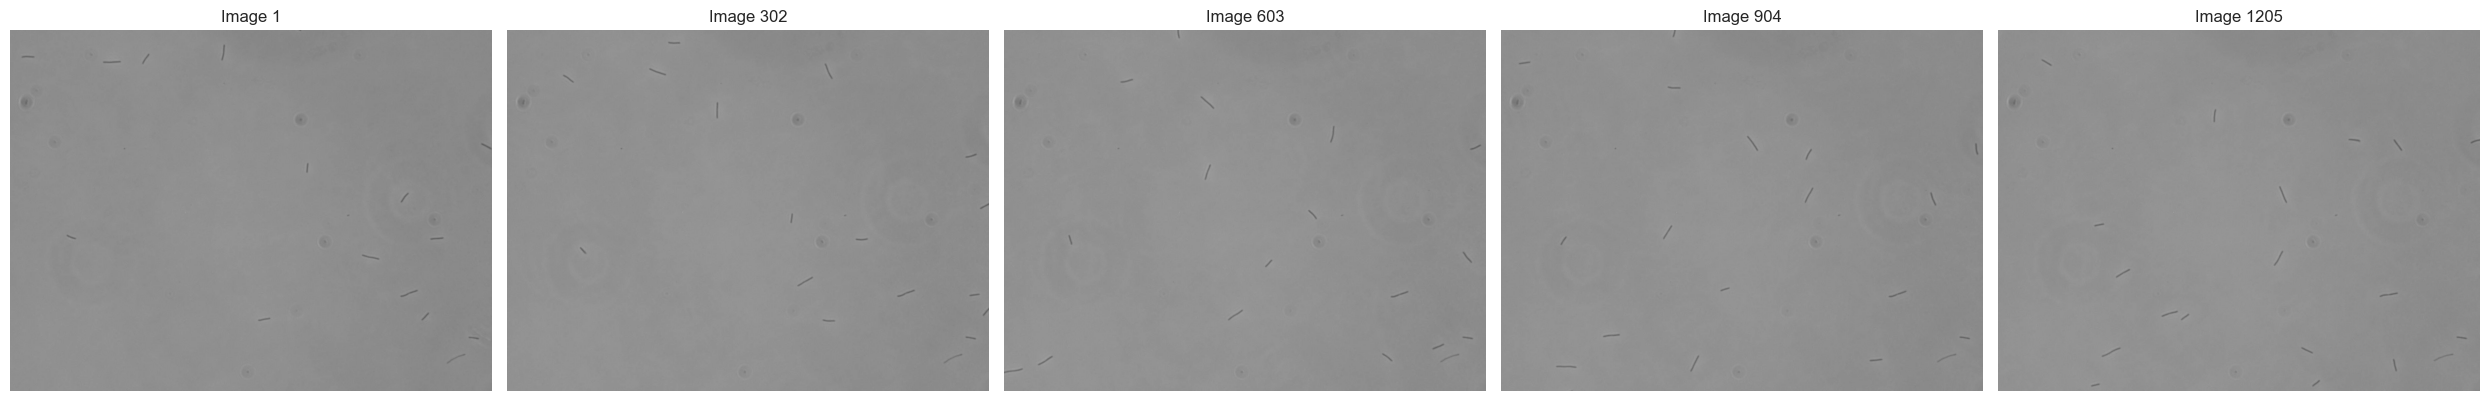

In [8]:
# Display the original frames
identify.show_frames(images_to_show_count=5, images_per_row=5, use_gray_cmap=True)

#### Generic-based detection

This section tells us about the generic/non-ai based gray-scale thresholding detection methods supported by this package to improve the visibility of microorganisms within the frames. This process will help to distinguish the organisms more clearly by adjusting the pixel intensity values.

This package offers three different thresholding methods:
- Manual Thresholding
- Algorithm-based Thresholding (using the scikit-learn library)
- Adaptive Gaussian Thresholding (using the OpenCV library)

*NOTE*: Choose only one method among the three, for better results.

##### 1. Manual Thresholding:
In this method, you manually set a threshold value between 0 and 1. Once applied, you can visualize the frames to observe how the organisms become more distinct.

Applying grayscale thresholding: 100%|██████████| 1509/1509 [00:18<00:00, 81.81it/s]


Threshold applied successfully.


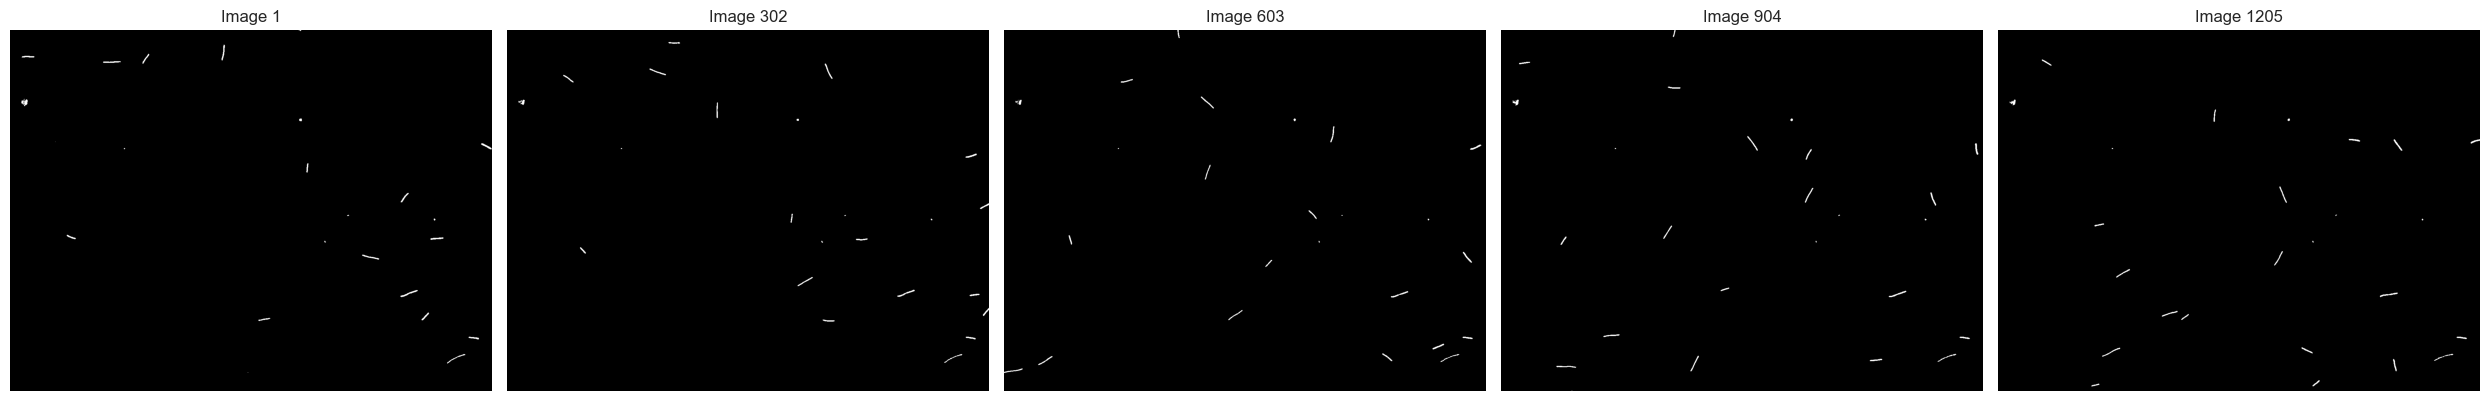

In [9]:
# Apply manual grayscale thresholding
identify.apply_grayscale_thresholding(threshold=0.52, is_update_frames=True)
identify.show_frames(images_to_show_count=5, images_per_row=5, use_gray_cmap=True)

**Tip:** Depending on the image quality and contrast, we can adjust the threshold values to achieve better results. Fine-tuning this parameter can significantly improve the clarity of the microorganisms in the frames. We already now through trial and error that the best threshold for the above images is 0.52.

##### 2. Algorithm-Based Thresholding

For a more automated thresholding approach, you can use this method. The following algorithms are available:
- 'isodata'
- 'li'
- 'mean'
- 'minimum'
- 'otsu'
- 'triangle'
- 'yen'

Learn more about these algorithms [here](https://scikit-image.org/docs/stable/api/skimage.filters.html#skimage.filters.try_all_threshold). To visualize the effect of each algorithm on a specific frame, use the `try_all_algorithm_based_thresholding` method. Simply provide the `frame_index` (0-based) to view the thresholding results. In the example below, we applied it to the first frame (index 0).

Following thresholding algorithms are applied: 'isodata', 'li', 'mean', 'minimum', 'otsu', 'triangle', 'yen'


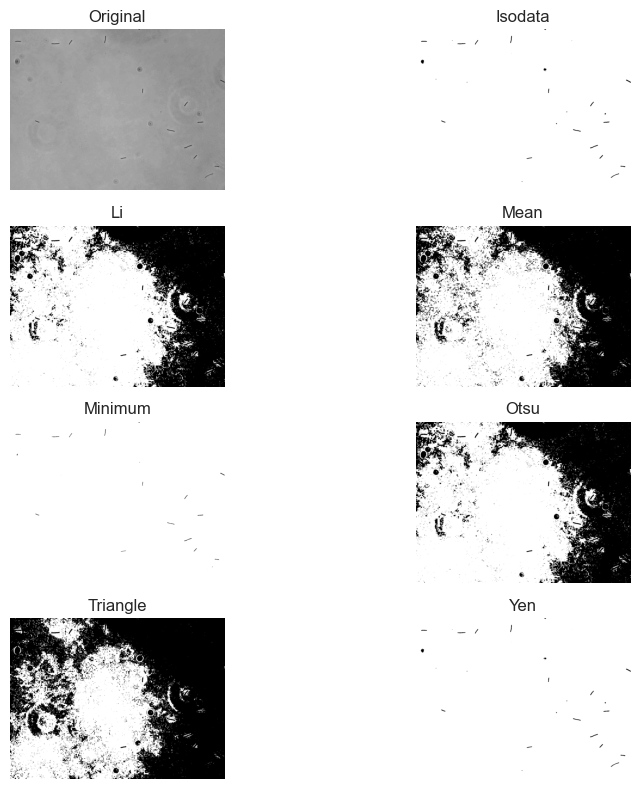

In [10]:
# Try algo based thresholding
identify.try_all_algorithm_based_thresholding(frame_index=0)

Once you have selected an algorithm, you can apply it to all the frames using the `apply_algorithm_based_thresholding` method. Provide the `algorithm`, `is_color_inverse`, and `is_update_frames` parameters. To visualize the final outputs, use the `show_frames` method, similar to the manual thresholding process.

NOTE: This package is particularly effective when dealing with lighter objects on a darker background. If the results are not as expected, you can set `is_color_inverse` to `True` to invert the results and try again. 

Applying algorithm-based thresholding: 100%|██████████| 1509/1509 [00:42<00:00, 35.56it/s]


Selected yen Algorithm-based thresholding applied successfully.
NOTE: If dark objects are displayed over a light background, set 'is_color_inverse' to True and redo the thresholding to correct it before proceeding to the next step.


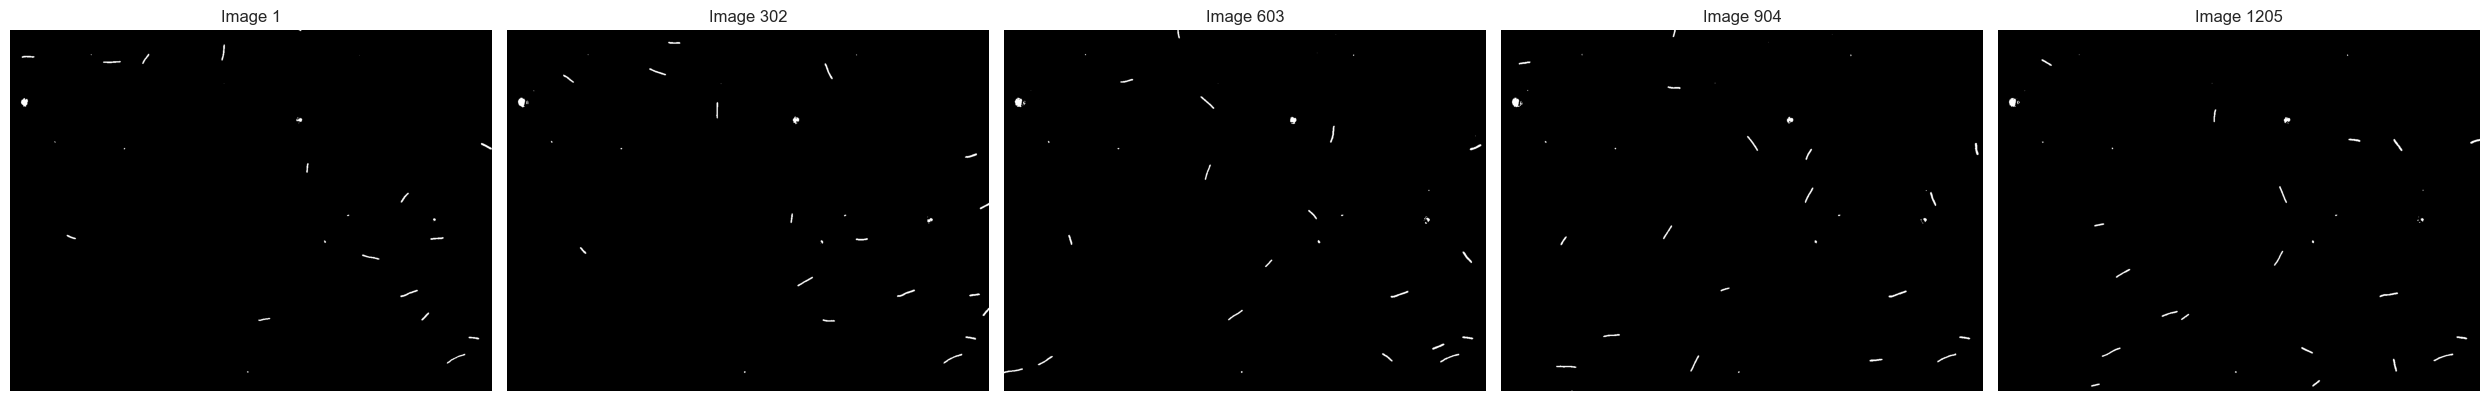

In [11]:
# Apply algo based grayscale thresholding
identify.apply_algorithm_based_thresholding(algorithm='yen', is_color_inverse=True, is_update_frames=True);
identify.show_frames(images_to_show_count=5, images_per_row=5, use_gray_cmap=True)

##### 3. Adaptive Gaussian Thresholding

Adaptive Gaussian Thresholding dynamically adjusts the threshold value based on the local pixel intensity variations within the frame. This method is effective for handling images with varying lighting conditions and contrasts. You can fine-tune the parameters to optimize the visibility of microorganisms.

To apply Adaptive Gaussian Thresholding, use the `apply_gaussian_adaptive_thresholding` method with the following parameters:
- `block_size`: Size of the local region (block) used to calculate the threshold for each pixel.
- `c`: Constant subtracted from the mean or weighted mean of the local region, which helps in adjusting the threshold.
- `is_color_inverse`: Set to `True` if the background is lighter than the objects and you need to invert the results.
- `is_update_frames`: Set to `True` to apply the thresholding to the frames.

Applying Gaussian adaptive thresholding: 100%|██████████| 1509/1509 [00:28<00:00, 52.20it/s]


Gaussian adaptive thresholding applied successfully.
NOTE: If dark objects are displayed over a light background, set 'is_color_inverse' to True and redo the thresholding to correct it before proceeding to the next step.


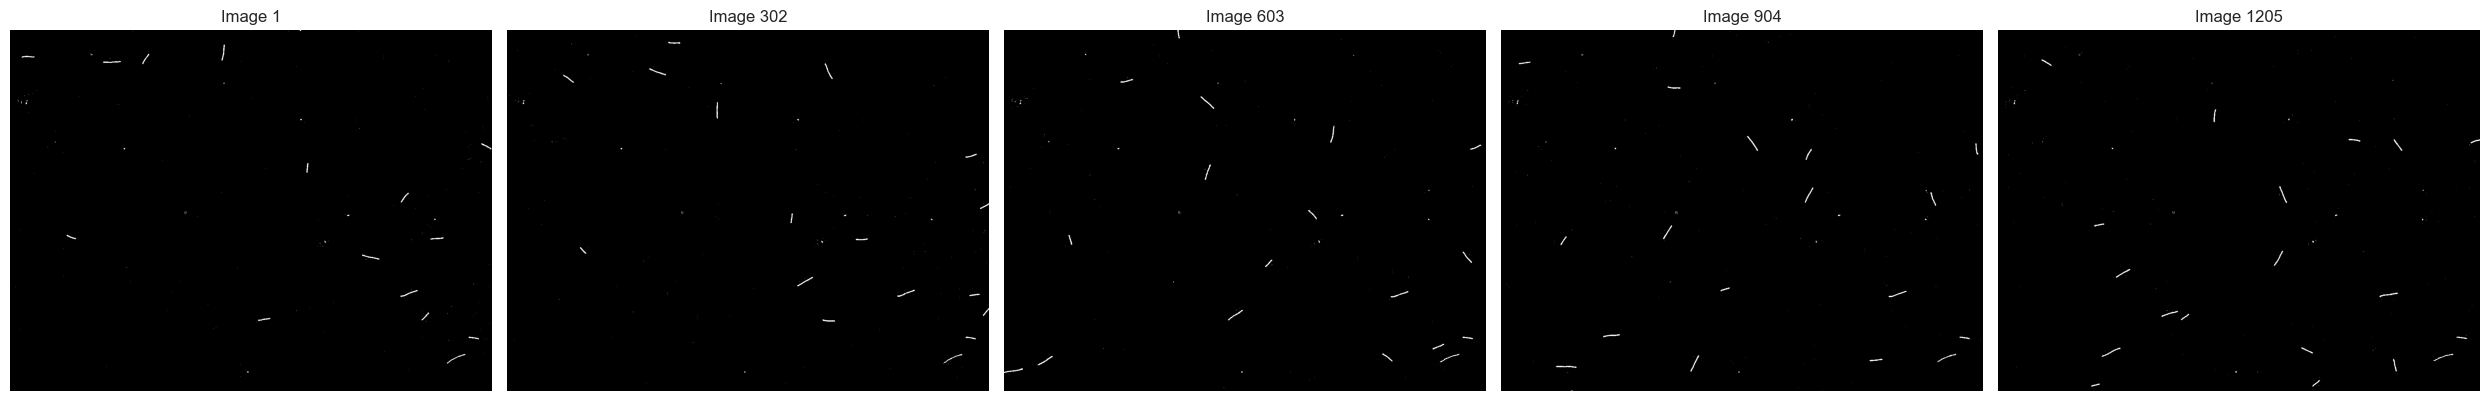

In [12]:
# Apply algo based grayscale thresholding
identify.apply_gaussian_adaptive_thresholding(block_size = 11, c = 5, is_color_inverse = True, is_update_frames = True);
identify.show_frames(images_to_show_count=5, images_per_row=5, use_gray_cmap=True)

#### AI-based detection

Incase thresholding does not lead to clear detection of the cell, `RABiTPy` also allows the user to perform AI-based detection of bacterial cells. 

We can create another variable 'identify_pose' and enhance the results further by utilizing a pose estimation algorithm that is pre-trained by other groups on image dataset of diverse bacteria (ref.). Before proceeding, we must initialize the model to optimize performance and accuracy. For more details on this model, you can refer to the [Omnipose documentation](https://omnipose.readthedocs.io/index.html).

In [13]:
identify_pose = Identify(capture_frame_object=capture)
identify_pose.initialize_omnipose_model(model_name='bact_phase_omni', use_gpu=True)

#Incase you don't want to use GPU, write 'use_gpu=False'.

[distfit] >INFO> ** TORCH GPU version installed and working. **
[distfit] >INFO> >>bact_phase_omni<< model set to be used
[distfit] >INFO> ** TORCH GPU version installed and working. **
[distfit] >INFO> >>>> using GPU


>>> GPU activated? True


Preparing frames for the omnipose model: 100%|██████████| 1509/1509 [00:18<00:00, 81.63it/s]

Frames prepared successfully for the omnipose model.
Omnipose model initialized successfully.


**Note:** model_name='bact_phase_omni' works well for phase contrast images. If we have a different type of image, eg. fluorescent, we can try other models. If want to know which Omnipose models are available, we can use the following function:

```python
identify.get_possible_omnipose_model_names()
```

This function will provide a list of possible models that we can choose from, allowing us to select the most suitable one for our analysis.

Next, we can proceed to apply the Omnipose library to our frames. Please be aware that this process can take a significant amount of time, depending on the complexity of your video, its duration, and the performance of your device. **For eg. An M1 Macbook Pro took around 31 mins with our sample.avi.**

In [14]:
# Apply Omnipose model
identify_pose.apply_omnipose_masking(batch_size=100, save_masks=True, masks_store_path='masks', is_update_frames=True);

Segmenting images:   0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

total segmentation time: 99.72492003440857s


Segmenting images:   6%|▋         | 1/16 [01:40<25:07, 100.51s/it]

Batch 1 segmentation is complete


  0%|          | 0/100 [00:00<?, ?it/s]

total segmentation time: 99.88027906417847s


Segmenting images:  12%|█▎        | 2/16 [03:21<23:28, 100.60s/it]

Batch 2 segmentation is complete


  0%|          | 0/100 [00:00<?, ?it/s]

total segmentation time: 98.88932299613953s


Segmenting images:  19%|█▉        | 3/16 [05:00<21:42, 100.18s/it]

Batch 3 segmentation is complete


  0%|          | 0/100 [00:00<?, ?it/s]

total segmentation time: 99.67016291618347s


Segmenting images:  25%|██▌       | 4/16 [06:41<20:03, 100.29s/it]

Batch 4 segmentation is complete


  0%|          | 0/100 [00:00<?, ?it/s]

total segmentation time: 99.4436731338501s


Segmenting images:  31%|███▏      | 5/16 [08:21<18:22, 100.27s/it]

Batch 5 segmentation is complete


  0%|          | 0/100 [00:00<?, ?it/s]

total segmentation time: 103.06817388534546s


Segmenting images:  38%|███▊      | 6/16 [10:05<16:54, 101.48s/it]

Batch 6 segmentation is complete


  0%|          | 0/100 [00:00<?, ?it/s]

total segmentation time: 104.5142080783844s


Segmenting images:  44%|████▍     | 7/16 [11:50<15:24, 102.73s/it]

Batch 7 segmentation is complete


  0%|          | 0/100 [00:00<?, ?it/s]

total segmentation time: 101.39468312263489s


Segmenting images:  50%|█████     | 8/16 [13:32<13:40, 102.55s/it]

Batch 8 segmentation is complete


  0%|          | 0/100 [00:00<?, ?it/s]

total segmentation time: 101.50734281539917s


Segmenting images:  56%|█████▋    | 9/16 [15:15<11:57, 102.46s/it]

Batch 9 segmentation is complete


  0%|          | 0/100 [00:00<?, ?it/s]

total segmentation time: 101.78582119941711s


Segmenting images:  62%|██████▎   | 10/16 [16:57<10:15, 102.50s/it]

Batch 10 segmentation is complete


  0%|          | 0/100 [00:00<?, ?it/s]

total segmentation time: 103.45358109474182s


Segmenting images:  69%|██████▉   | 11/16 [18:41<08:35, 103.03s/it]

Batch 11 segmentation is complete


  0%|          | 0/100 [00:00<?, ?it/s]

total segmentation time: 98.52699899673462s


Segmenting images:  75%|███████▌  | 12/16 [20:21<06:47, 101.90s/it]

Batch 12 segmentation is complete


  0%|          | 0/100 [00:00<?, ?it/s]

total segmentation time: 103.40254092216492s


Segmenting images:  81%|████████▏ | 13/16 [22:05<05:07, 102.59s/it]

Batch 13 segmentation is complete


  0%|          | 0/100 [00:00<?, ?it/s]

total segmentation time: 112.13325691223145s


Segmenting images:  88%|████████▊ | 14/16 [23:58<03:31, 105.71s/it]

Batch 14 segmentation is complete


  0%|          | 0/100 [00:00<?, ?it/s]

total segmentation time: 108.97769093513489s


Segmenting images:  94%|█████████▍| 15/16 [25:48<01:46, 106.93s/it]

Batch 15 segmentation is complete


  0%|          | 0/9 [00:00<?, ?it/s]

Segmenting images: 100%|██████████| 16/16 [25:58<00:00, 97.38s/it] 

total segmentation time: 9.88135290145874s
Batch 16 segmentation is complete
Objects segmented successfully using the omnipose model.


Let's check the output after the AI-based identification. This will allow us to visualize the results and see how the microorganisms have been identified and segmented by the model.

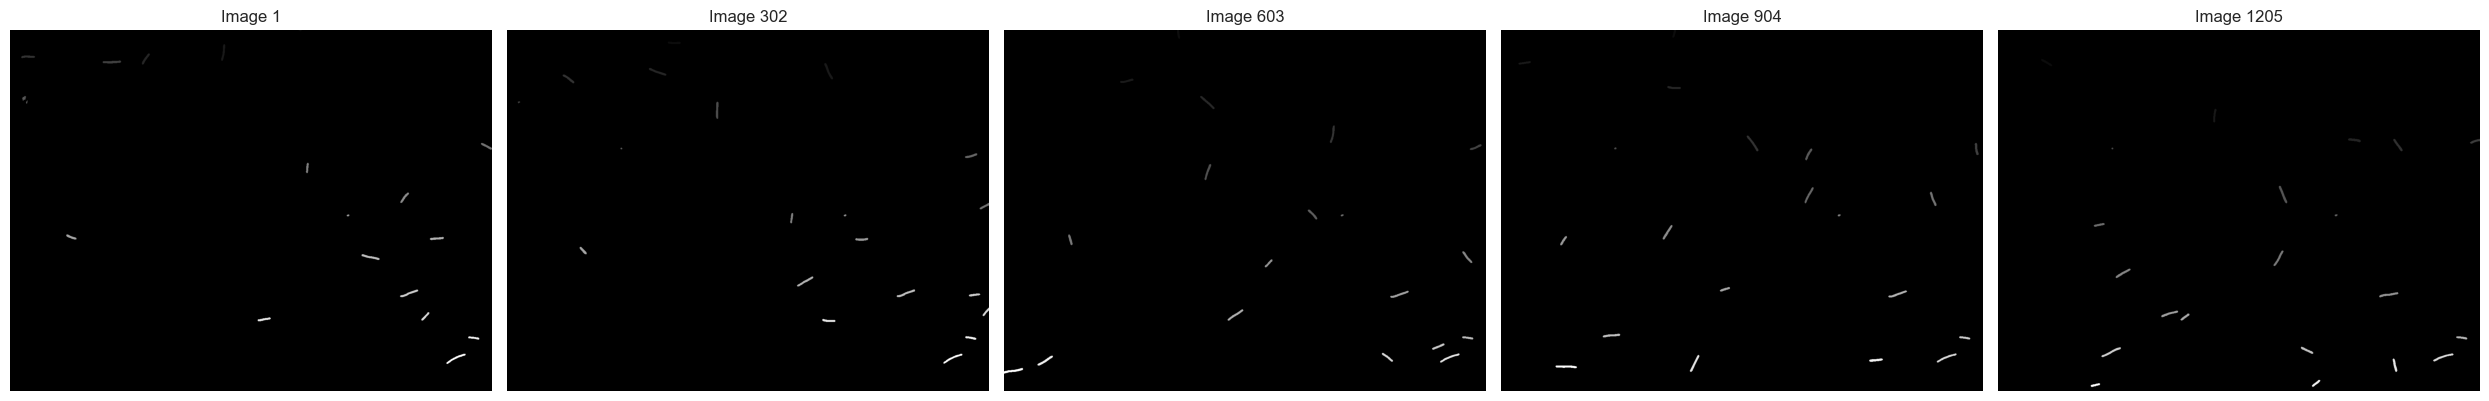

In [15]:
# # Display frames after applying grayscale thresholding
identify_pose.show_frames(images_to_show_count=5, images_per_row=5, use_gray_cmap=True)

Tip: Use this method ```identify.apply_color_inverse(is_update_frames=True)``` to update and inverse the colors of the frames.

#### Feature Scoping

In the next step, we will generate region properties for the frames to identify particles(in each frame) and their features, such as:
- AREA
- CENTROID
- MAJOR_AXIS_LENGTH
- MINOR_AXIS_LENGTH

We can create a DataFrame containing these properties using the following code.

In [16]:
# Specify the properties you want to view
view_props = [
    AvailableProps.LABEL, # Label is mandatory for the region properties
    AvailableProps.AREA,
    AvailableProps.CENTROID,
    AvailableProps.MAJOR_AXIS_LENGTH,
    AvailableProps.MINOR_AXIS_LENGTH
]

# Generate region properties for the frames and store them in a DataFrame
region_props_df = identify.generate_region_props_to_dataframe(view_props)

# Display the DataFrame
region_props_df

Generating region properties: 100%|██████████| 1509/1509 [00:36<00:00, 40.83it/s]

Region properties generated successfully.


,label,area,centroid_x,centroid_y,major_axis_length,minor_axis_length,frame
0,1,29.0,2.137931,864.758621,12.493248,3.310286,1
1,2,1.0,7.000000,367.000000,0.000000,0.000000,1
2,3,1.0,7.000000,831.000000,0.000000,0.000000,1
3,4,1.0,7.000000,1040.000000,0.000000,0.000000,1
4,5,168.0,69.636905,637.148810,55.427600,4.617084,1
...,...,...,...,...,...,...,...
224517,143,97.0,1028.804124,394.237113,30.678144,4.395161,1509
224518,144,102.0,1038.882353,969.411765,33.194357,4.094999,1509
224519,145,1.0,1040.000000,1242.000000,0.000000,0.000000,1509
224520,146,1.0,1040.000000,1336.000000,0.000000,0.000000,1509


#### Gaussian Fit on Centroids to Increase Accuracy (Optional step, can be skipped)

Accurate centroid localization is critical for downstream analyses such as tracking. Rather than relying on an intensity-weighted mean—which can be less reliable in low-magnification videos where bacteria appear more circular—we use a localized Gaussian fit. By applying a Gaussian model only to a small region surrounding each detected feature, we reduce noise and avoid interference from nearby objects, leading to more precise centroid determination.

There are two key methods implemented:

1. **`visualize_gaussian_fit_on_a_frame`**  
   This method allows you to test and visually assess the Gaussian fitting process on a single frame (e.g., frame 1). In this visualization:
   - The method uses the stored working frame along with its region properties.
   - For each detected feature, a sub-image is extracted using a window size of 10 pixels (resulting in a 20×20 pixel area centered on the feature).
   - A 2D Gaussian is fitted to the intensity profile in each sub-image to compute a refined centroid.
   - The initial centroids (displayed as blue circles) and the refined centroids (displayed as green stars) are overlaid on the complete frame.

   This visual output helps you confirm that the Gaussian refinement is accurately adjusting the centroids.


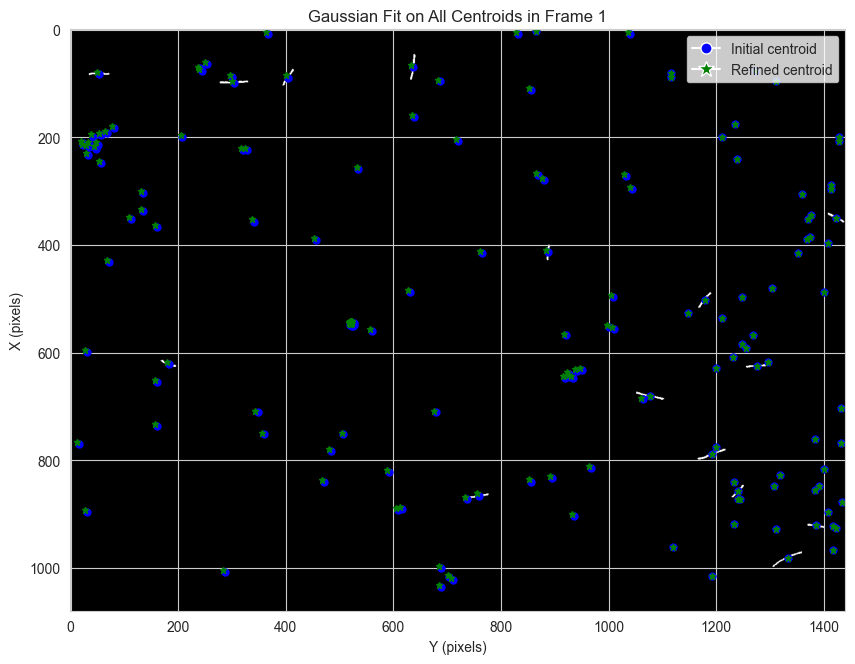

In [17]:
identify.visualize_gaussian_fit_on_a_frame(frame_index=1, fit_window=7)

2. **`optimize_centroids_using_gaussian_fit`**  
   Once you’re satisfied with the results from the visualization, this method processes all frames in parallel to refine centroids across your dataset:
   - For each frame, a sub-image is extracted around each detected centroid using a fit window of given pixels(as arguments).
   - A 2D Gaussian function is fitted to the sub-image, and the refined (more precise) centroid is calculated.
   - The internal region properties DataFrame is updated with these refined centroids, thereby improving the accuracy of all subsequent analyses, such as particle tracking.

In [18]:
identify.optimize_centroids_using_gaussian_fit(fit_window=7)

Updating centroids: 100%|██████████| 1509/1509 [02:47<00:00,  9.00it/s]

Centroids optimized successfully using Gaussian fit.


This will generate a DataFrame containing the specified region properties for each identified particle in the frames, allowing you to analyze their characteristics in detail.

Please note that we must use the AvailableProps enumerations (eg. AvailableProps.CENTROID) when specifying the properties to supply to the function. This ensures that the function correctly interprets the requested properties and generates the appropriate region properties DataFrame. 

Now, we can apply multiple filters to the calculated region properties, such as filtering by properties that are less than or greater than a specified value. These filters can be combined using logical 'AND' operations. The implementation is shown below. We can use the `AvailableProps` enumerations for property values and `AvailableOperations` enumerations for specifying the operations.

In [19]:
# importing the list module
from typing import List

# Apply filters on region properties
props_threshold: List[PropsThreshold] = [
    {
        'property': AvailableProps.AREA,               # Property to filter on
        'operation': AvailableOperations.GREATER_THAN, # Operation to perform
        'value': 86                                    # Value to compare with
    }
]

# Apply filters on the generated region properties
filtered_df = identify.apply_filters_on_region_props(props_threshold, is_update_dataframes = True)

Filters applied successfully.


In above implementation, The filter selects regions where the `AREA` is greater than 86.

NOTE: These filters are combined with 'AND', meaning that only regions meeting all specified conditions will be included in the resulting DataFrame.

#### Feature Plotting

To finalize the analysis, you can use the `plot_centroids` function to visualize the motility of the biomes. This will allow you to observe how the centroids of the identified objects move across the frames. After that, you can save the results to a CSV file using the `save_identified_objects_to_csv` function for further analysis or record-keeping.

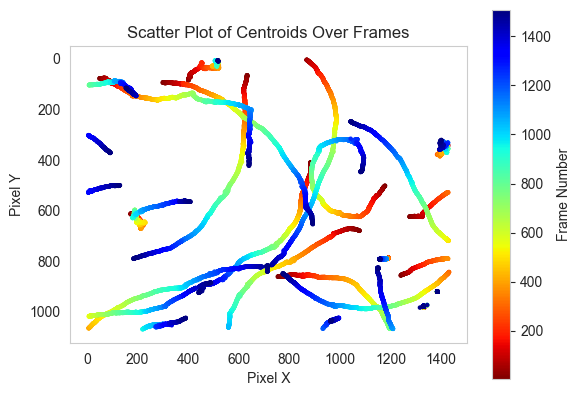

Identified objects saved successfully to path:  input_files/identified_objects.csv


In [20]:
# Plot the filtered region properties
identify.plot_centroids(show_time=True)

# Save identified objects to CSV
identify.save_identified_objects_to_csv(output_file_name='identified_objects')

### Step 3: Tracking

In this step, we connect the centroids of the microbes together across the frames to create a trajectory for each microbial cell. This process allows us to track the movement of individual microbes over time, forming a continuous path or trajectory for each identified object.

To perform this tracking, we will need to supply the `identify` object, created in the previous steps, to the tracking module. This ensures that the tracking process is based on the objects and properties identified earlier.

In [21]:
tracker = Tracker(identify_object=identify)

To further refine the tracking process, you can link particles across frames and apply filters to ensure that only relevant trajectories are retained. The following code demonstrates how to link particles and filter them based on criteria such as minimum frames and displacement.

In [22]:
# Link particles across frames
tracker.link_particles(max_distance=50, max_memory=50, position_columns=['centroid_x', 'centroid_y'])

# Filter particles to retain only those with a minimum number of frames and displacement
tracker.filter_particles(min_frames=500, min_displacement=10, is_update_particles=True)

Frame 1509: 22 trajectories present.
Successfully linked 28 particles.
After filtering based on min 500 frames: 19 unique particles
After filtering based on min 10 displacement filtering: 17 unique particles


,label,area,centroid_x,centroid_y,major_axis_length,minor_axis_length,frame,particle
frame,,,,,,,,
1,5,168.0,65.500000,633.500000,55.427600,4.617084,1,0
1,128,126.0,861.500000,754.500000,42.437067,4.068613,1,3
1,102,179.0,680.396648,1077.229050,61.792994,4.168379,1,5
1,114,191.0,788.685864,1191.549738,63.142373,4.540475,1,7
1,68,127.0,502.086614,1178.275591,40.955838,4.616881,1,8
...,...,...,...,...,...,...,...,...
1509,58,140.0,422.500000,640.500000,44.431485,4.485699,1509,12
1509,42,127.0,321.307087,1400.929134,40.673902,4.543454,1509,10
1509,30,153.0,248.500000,1042.500000,48.112095,4.677284,1509,18


The explanation for the tracking can be as follows:
1. **Linking Particles:**
   - `max_distance=50`: The maximum distance allowed between consecutive particle positions for them to be linked together in a trajectory.
   - `max_memory=50`: The number of frames in which a particle can be "forgotten" and later relinked if it reappears within the allowed distance.
   - `position_columns=['centroid_x', 'centroid_y']`: Specifies the columns representing the x and y coordinates of the centroid for linking purposes.

2. **Filtering Particles:**
   - `min_frames=500`: Filters out particles that appear in fewer than 500 frames.
   - `min_displacement=10`: Filters out particles that have a displacement (movement) less than 10 units, ensuring only significant movements are tracked.
   - `is_update_particles=True`: Updates the particle trajectories based on the filtering criteria, removing those that do not meet the minimum frame and displacement requirements.

To save the results to a CSV file we can do the following:

In [23]:
# Save linked dataframes
tracker.save_linked_dataframes(output_file_name='linked_particles')

Linked dataframes saved to input_files/linked_particles.csv


#### Plotting the tracks

To visualize the tracks from different perspectives, here are some functions that can help you better understand the movements:

##### 1. Plot trajectories:

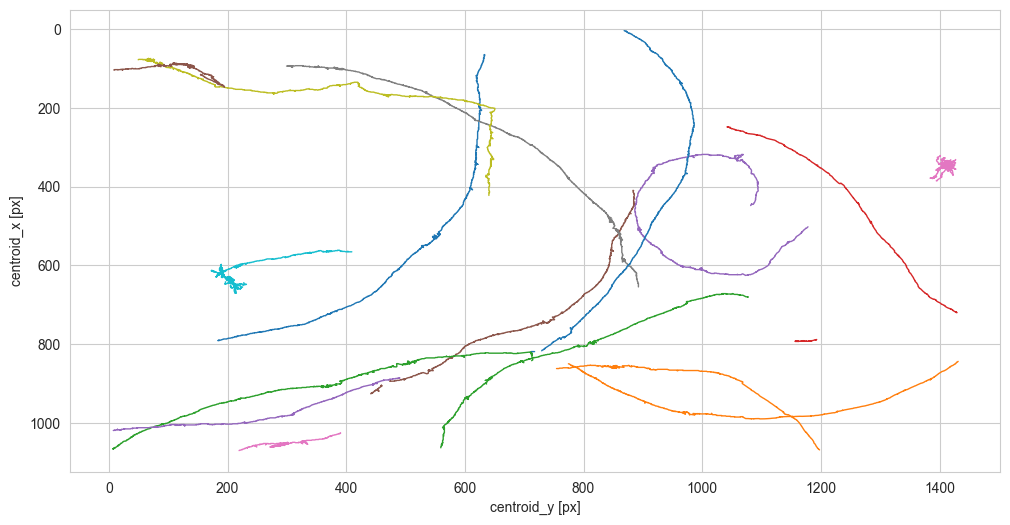

Trajectories plotted successfully.


In [24]:
# Plot trajectories using line plot - No labels
tracker.plot_trajectories_using_trackpy()

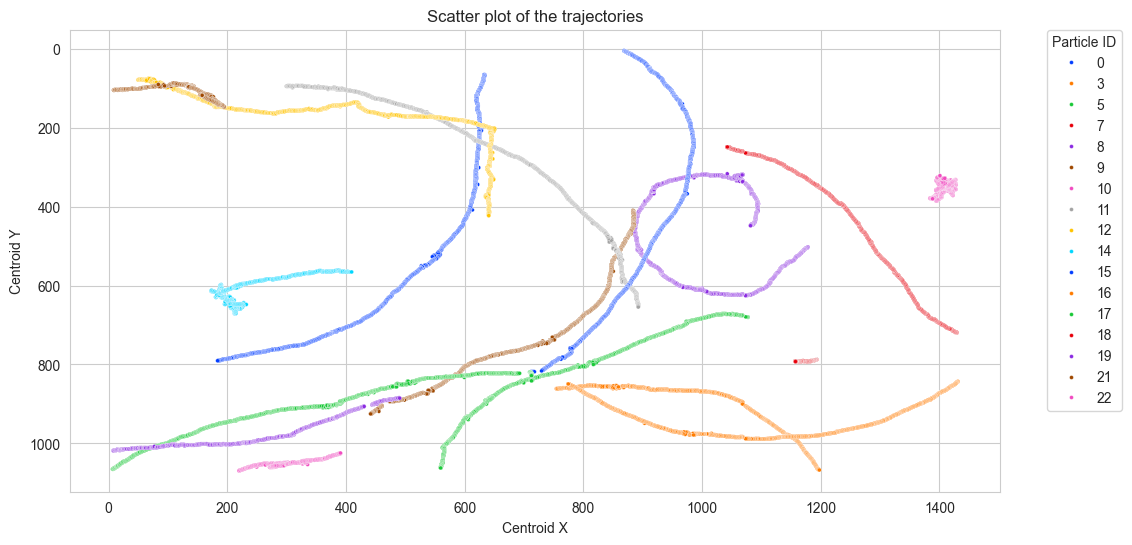

In [25]:
# Plot trajectories using scatter plot
tracker.sort_and_plot_scatter_of_trajectories()

##### 2. Visualize the movements from an origin point perspective to analyze their direction and the distance they have traveled.

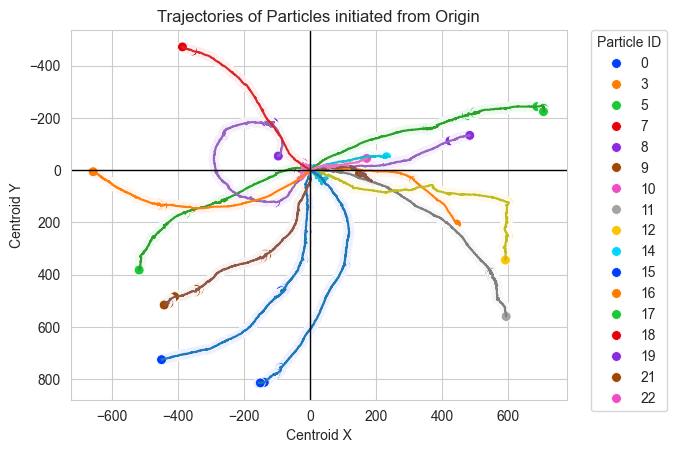

In [26]:
# Scatter plot around origin
tracker.visualize_particle_trajectories_from_origin()

##### 3. Visualize a heatmap that illustrates the overall motility patterns covered by the biomes collectively.

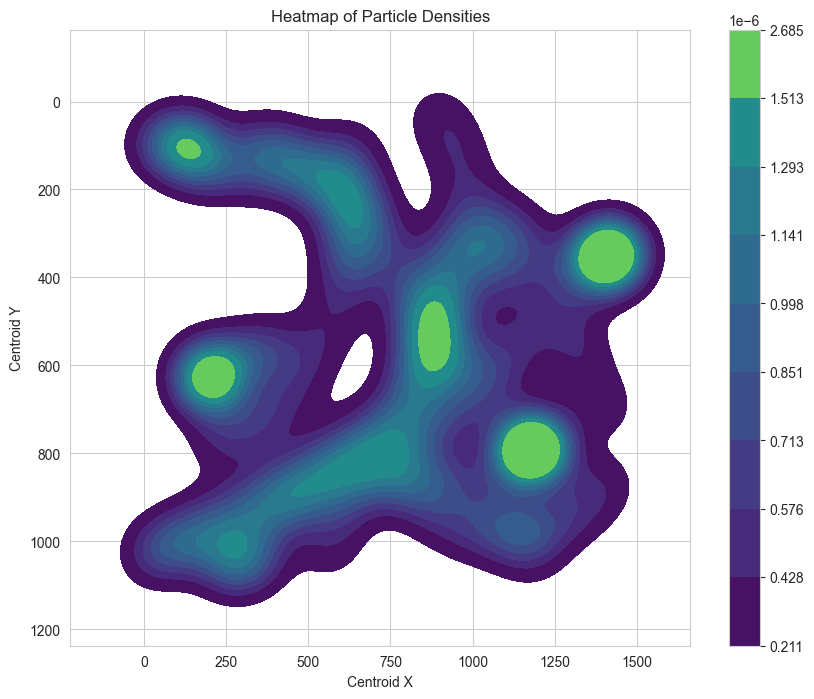

In [27]:
# Heatmap of particles
tracker.visualize_particle_heatmap()

##### 4. Visualize an overlay of the tracks on the input video. (with Labels)

In [28]:
# Overlay tracks on video
tracker.overlay_tracks_on_video(
    output_video_filename="tracks_overlaid.avi",
    colormap_name="viridis",
    show_labels=True
)

Overlaying Tracks on Video: 100%|██████████| 1509/1509 [00:39<00:00, 38.26it/s]

Processed video with overlaid tracks saved to input_files/tracks_overlaid.avi


### Step 4: Statistics

In this step, all relevant statistics are calculated. As with previous steps, you need to supply the `tracker` object to the `Stat` class to perform the calculations. After that, we calculate the speeds, apply a normal distribution to these values, and then plot the results.

`calculate_speed_and_plot_mean` functions allow you to fit and plot the speed distribution of particles tracked over time. The fitting is performed on a subset of the data defined either by a user-specified range or by a default confidence interval. Two plots are generated:
- A histogram of the full speed dataset with the fit range highlighted. 
- A plot of the fitted distribution (e.g., Gaussian, exponential, etc.) for the selected range with the mean speed marked.

Total unique particles: 17


Calculating Speed:   0%|          | 0/17 [00:00<?, ?it/s]

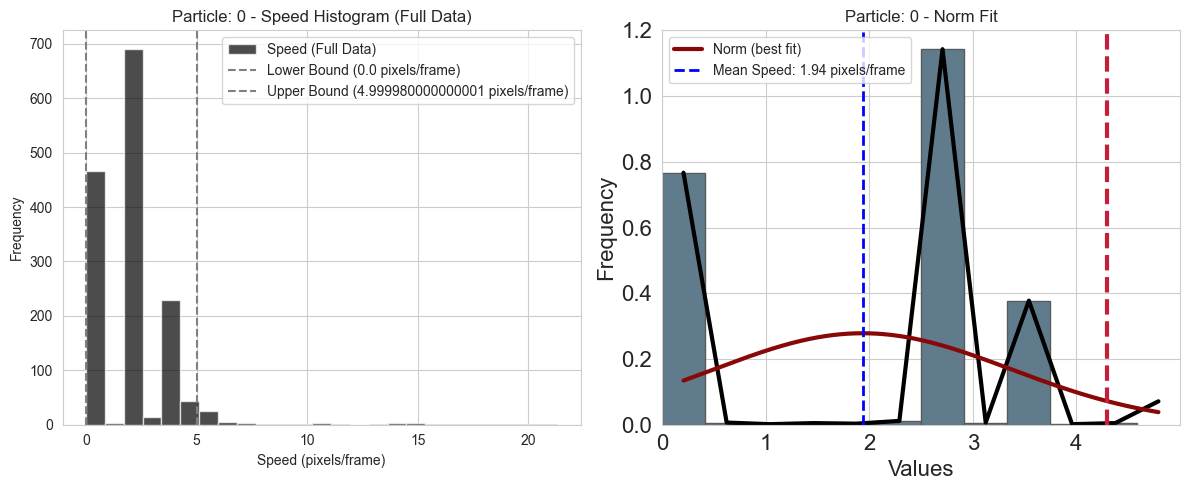

Calculating Speed:   6%|▌         | 1/17 [00:00<00:05,  3.20it/s]

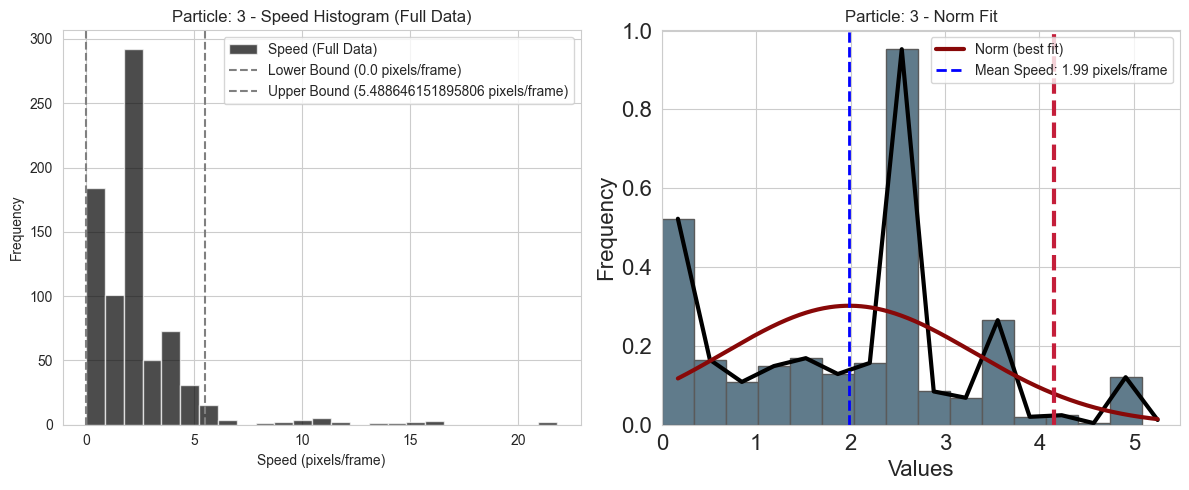

Calculating Speed:  12%|█▏        | 2/17 [00:00<00:04,  3.42it/s]

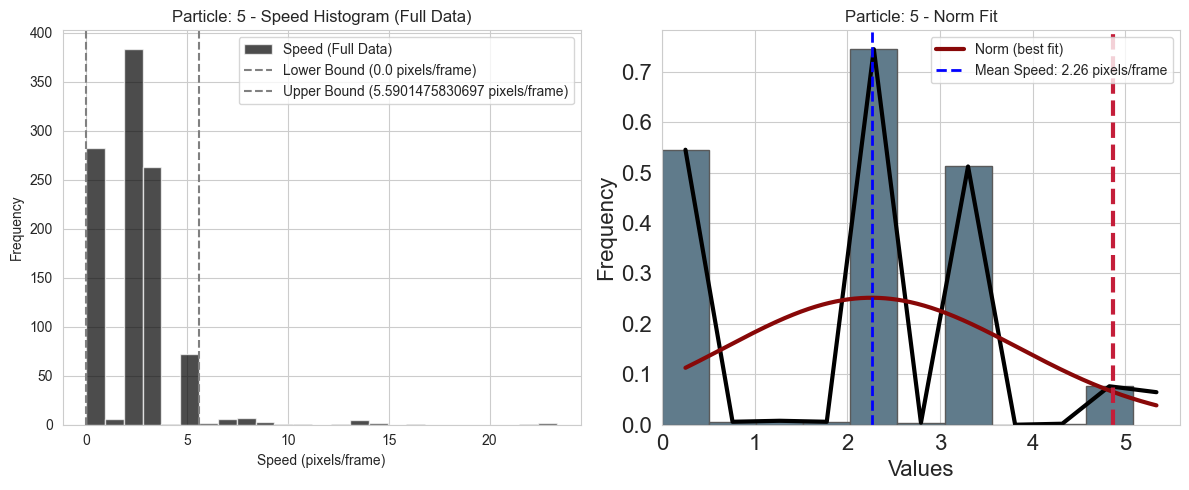

Calculating Speed:  18%|█▊        | 3/17 [00:01<00:05,  2.42it/s]

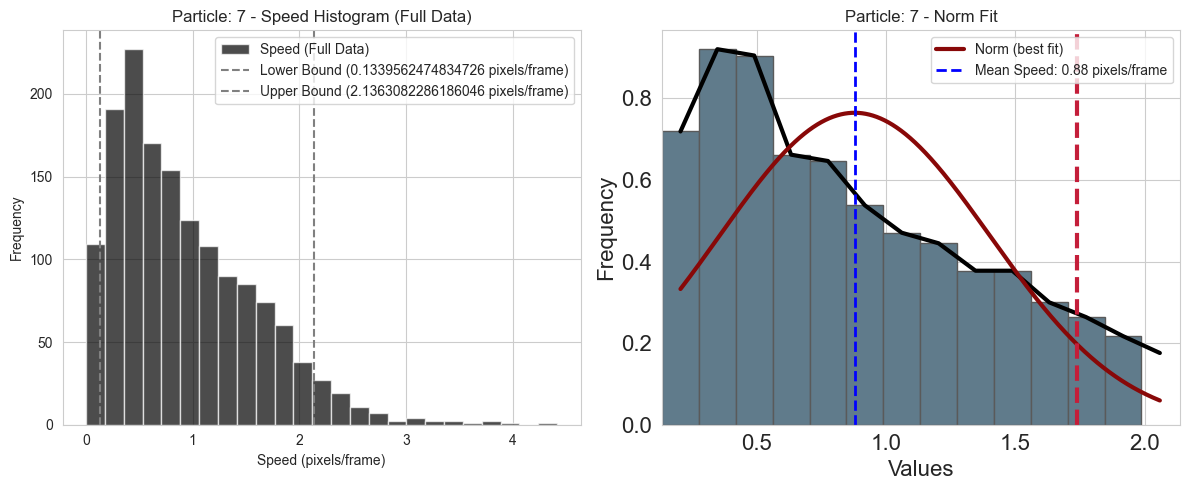

Calculating Speed:  24%|██▎       | 4/17 [00:01<00:04,  2.78it/s]

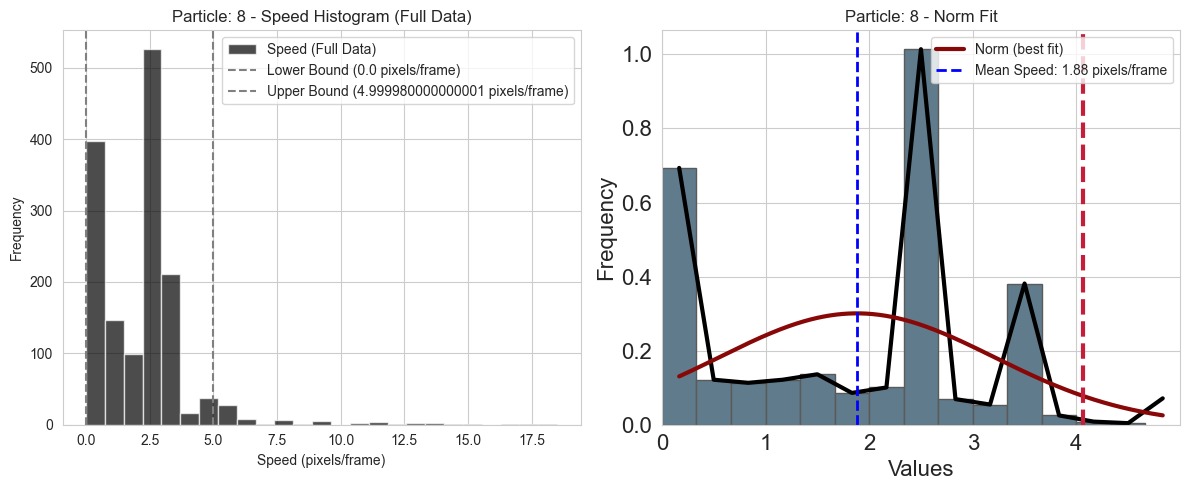

Calculating Speed:  29%|██▉       | 5/17 [00:01<00:04,  2.86it/s]

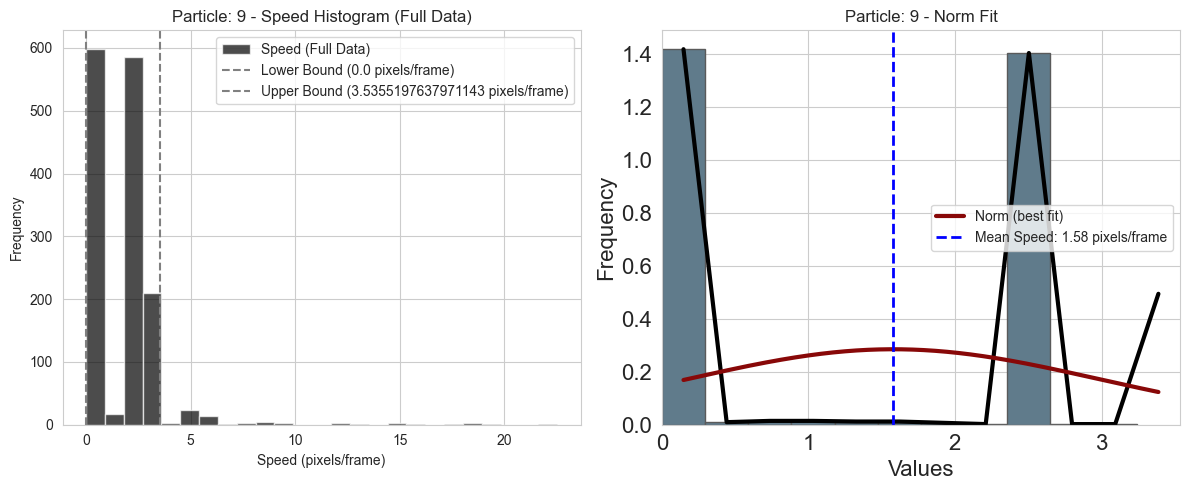

Calculating Speed:  35%|███▌      | 6/17 [00:02<00:03,  3.03it/s]

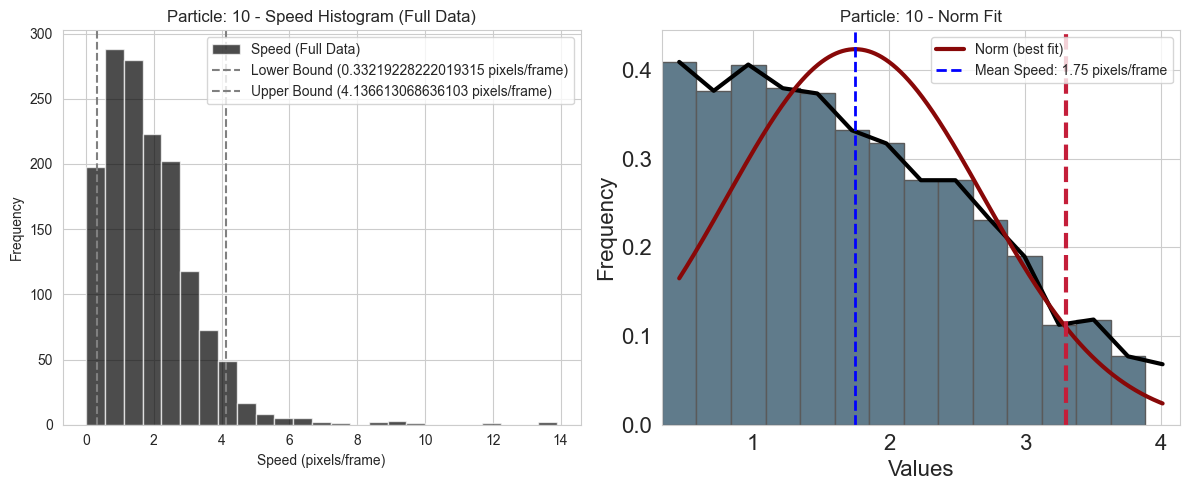

Calculating Speed:  41%|████      | 7/17 [00:02<00:03,  3.14it/s]

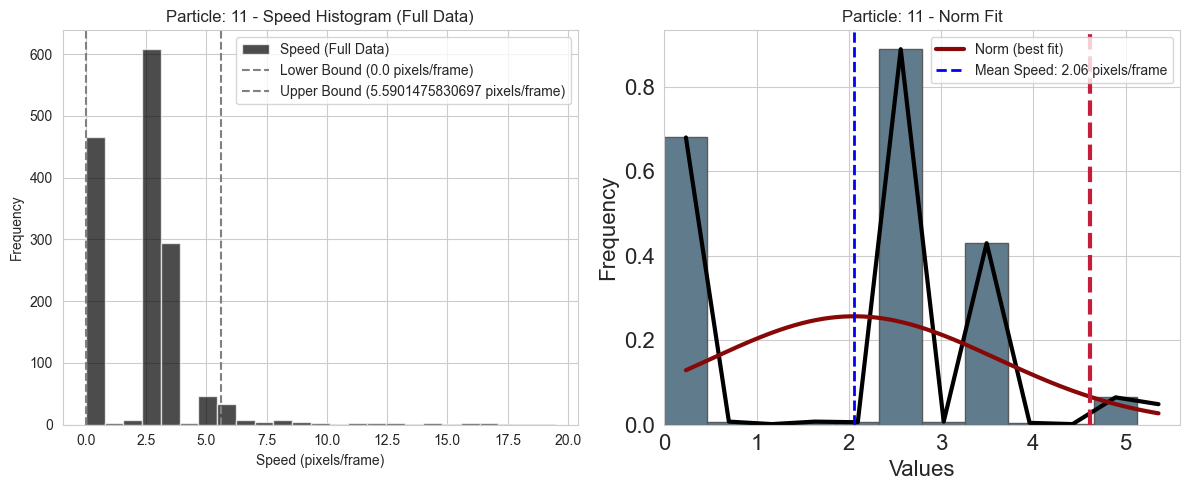

Calculating Speed:  47%|████▋     | 8/17 [00:02<00:02,  3.25it/s]

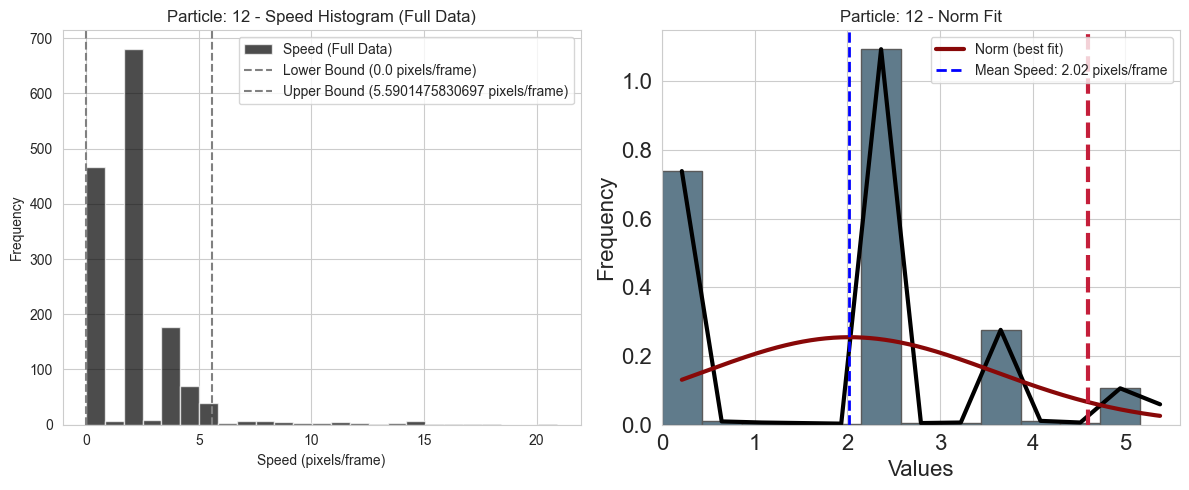

Calculating Speed:  53%|█████▎    | 9/17 [00:02<00:02,  3.16it/s]

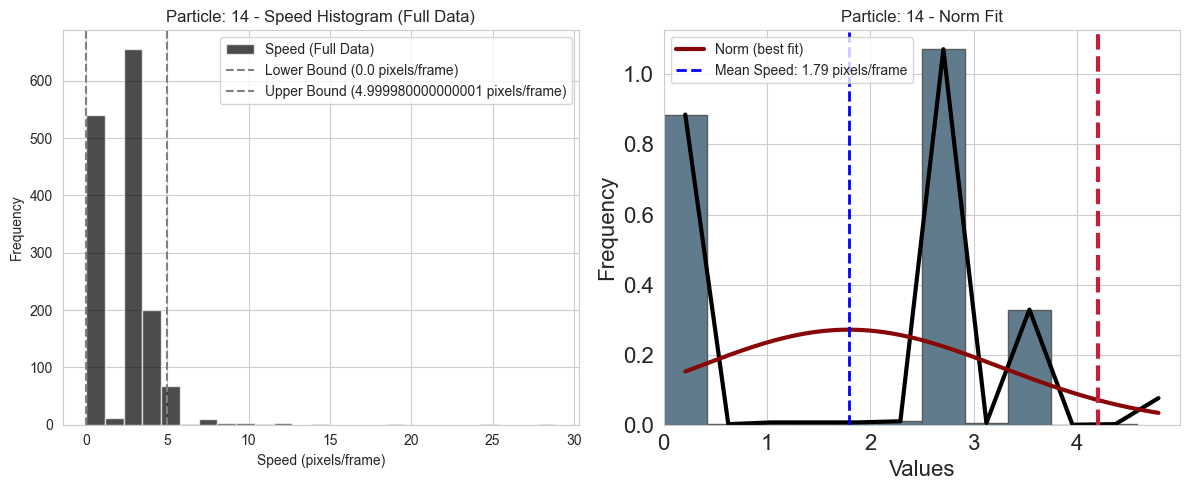

Calculating Speed:  59%|█████▉    | 10/17 [00:03<00:02,  3.25it/s]

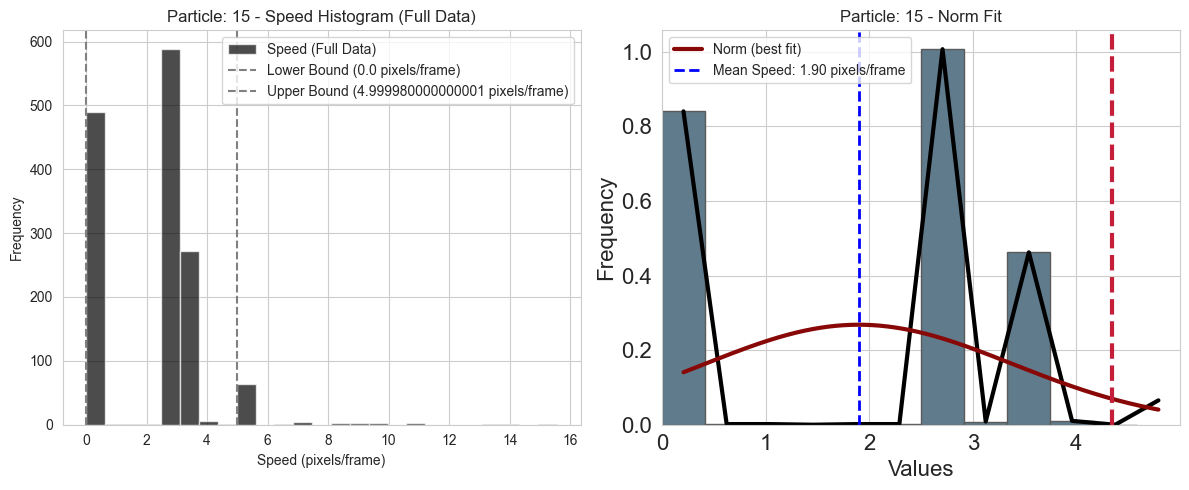

Calculating Speed:  65%|██████▍   | 11/17 [00:03<00:01,  3.29it/s]

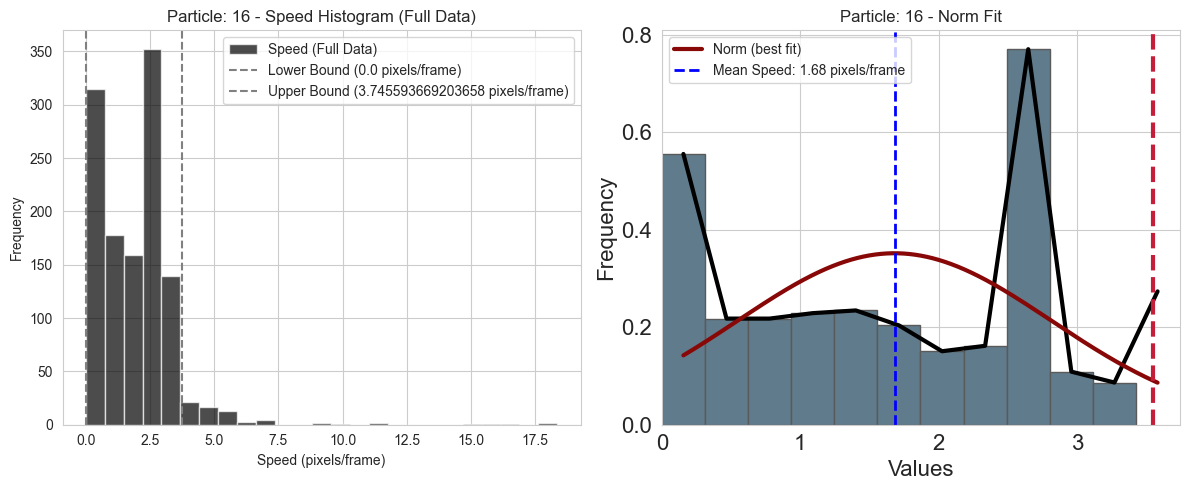

Calculating Speed:  71%|███████   | 12/17 [00:03<00:01,  3.26it/s]

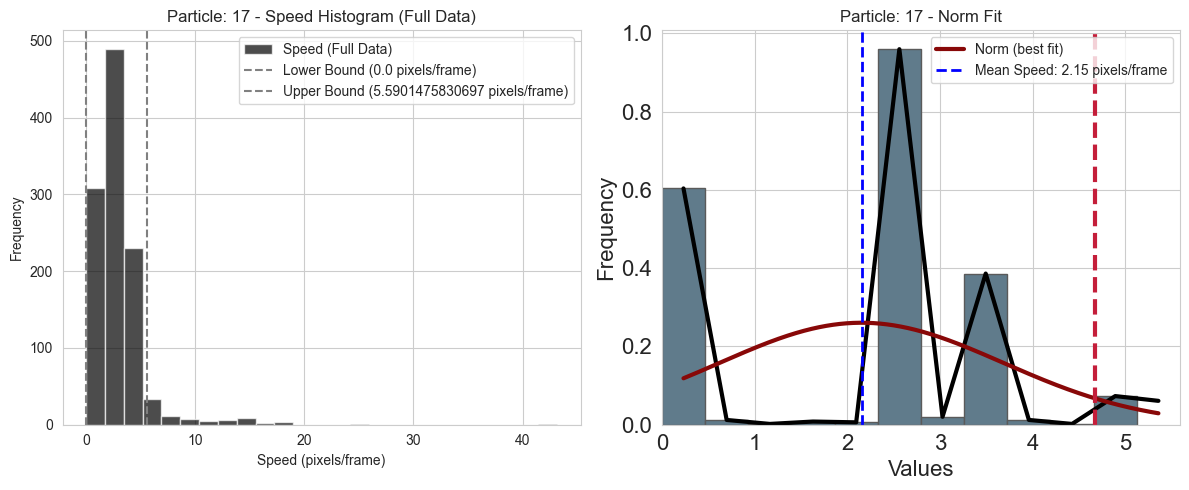

Calculating Speed:  76%|███████▋  | 13/17 [00:04<00:01,  3.36it/s]

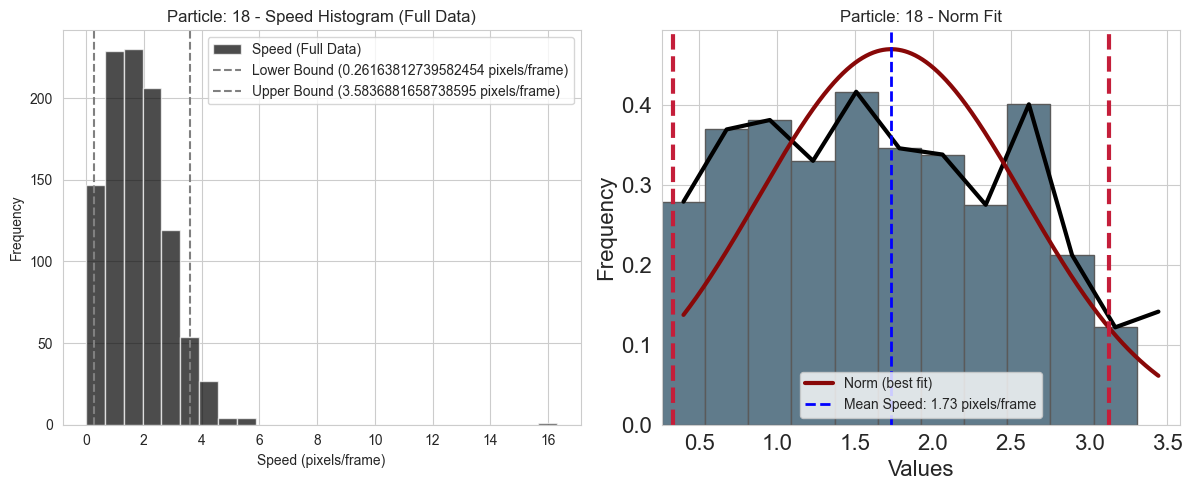

Calculating Speed:  82%|████████▏ | 14/17 [00:04<00:00,  3.35it/s]

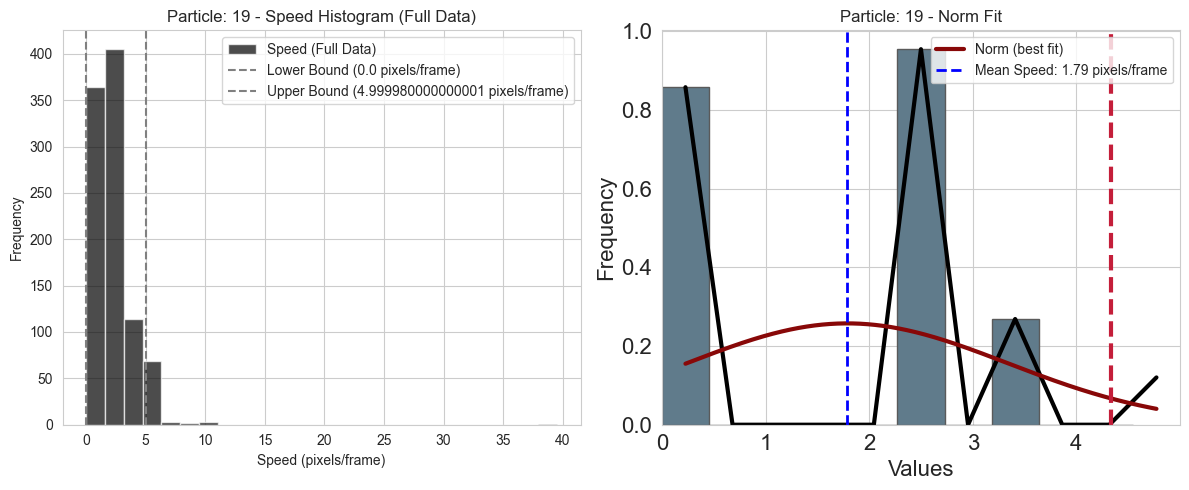

Calculating Speed:  88%|████████▊ | 15/17 [00:04<00:00,  3.27it/s]

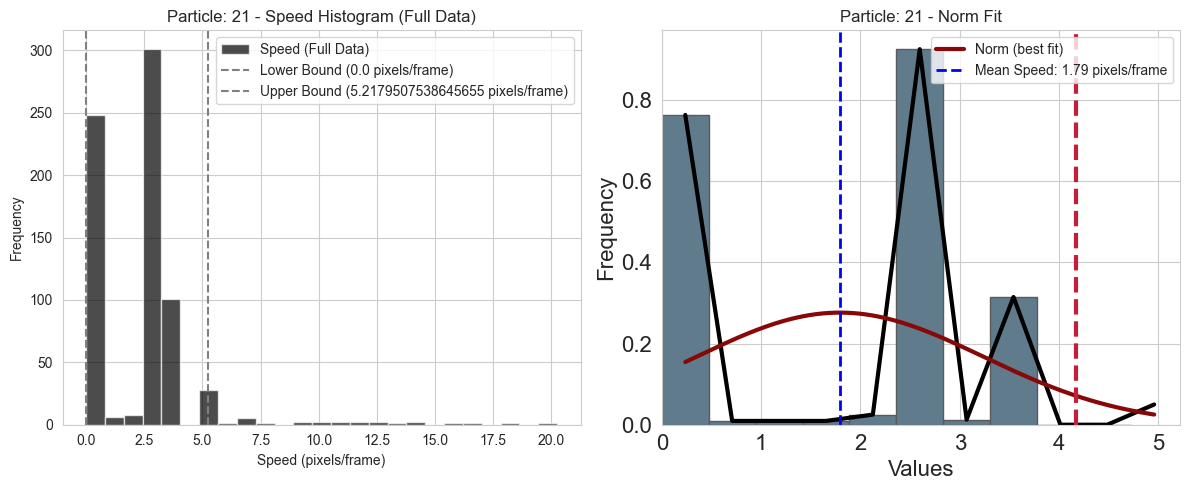

Calculating Speed:  94%|█████████▍| 16/17 [00:05<00:00,  3.32it/s]

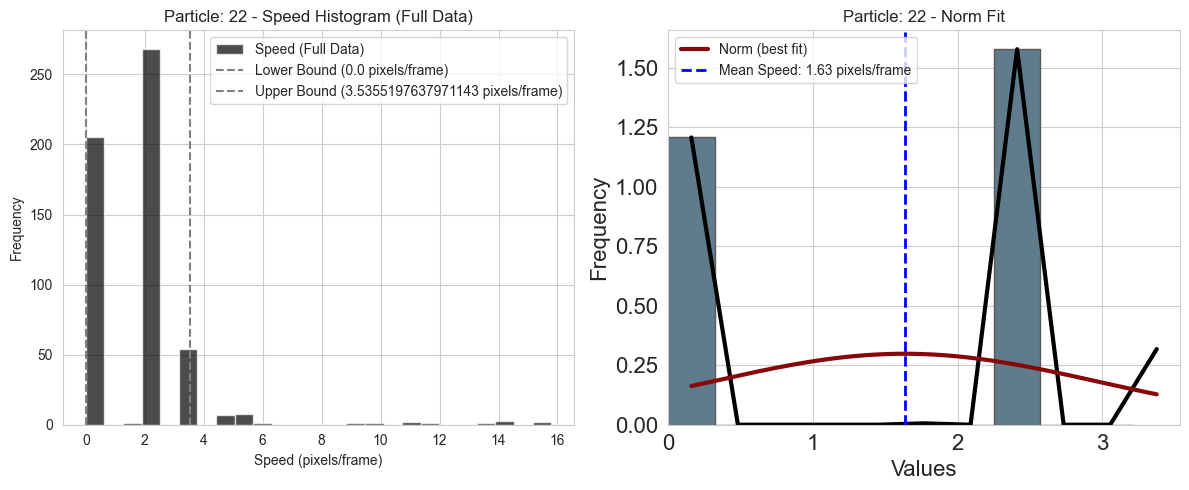

Calculating Speed: 100%|██████████| 17/17 [00:05<00:00,  3.19it/s]


array([1.93718221, 1.98522964, 2.26167445, 0.87907971, 1.88109538,
       1.57851997, 1.75195782, 2.05670599, 2.02278742, 1.7912038 ,
       1.89853918, 1.68185823, 2.15374381, 1.73133371, 1.7885912 ,
       1.79359133, 1.63369505])

In [29]:
# Initialize the stats object with the tracker object
stats = Stats(tracker_object=tracker)

# Calculate the speed and plot the mean of the distribution
stats.calculate_speed_and_plot_mean(distribution_type='norm', ci_range=(5, 95), bin_size=25, speed_unit='pixels/frame')

We can calculate the overall mean speed distribution and generate a histogram visualization to better understand the distribution of speeds. Additionally, the mean speeds can be saved to a CSV file for further analysis or record-keeping.

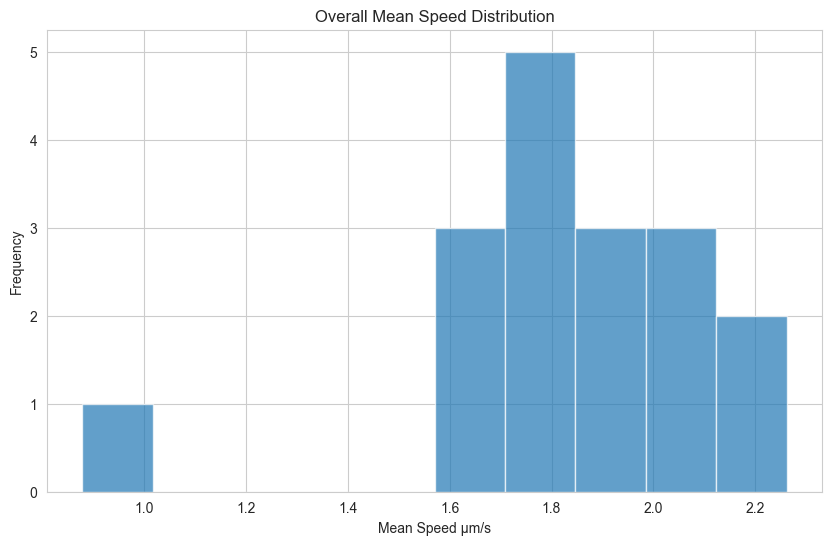

Mean speeds saved to input_files/mean_speeds.csv


In [30]:
# plot the overall mean speed distribution
stats.plot_overall_mean_speed_distribution(bins=10, speed_unit='µm/s')

# Save the mean speeds to a CSV file
stats.save_mean_speeds(filename='mean_speeds')

Finally, we can see the mean speed of the particles in the video. This is just a simple example of how you can use the RABiTPy package to analyze videos of microorganisms. You can further customize the analysis by changing the parameters and functions used in the package.

### Additional Notebooks for other use cases:
- [Combining the Linked Dataframes to get their trajectories together](Additional%20examples/Combining%20Multiple%20Tracks.ipynb)
- [Dual Channel Video Handling](Additional%20examples/Dual%20Channel.ipynb)